# Co-Attention Siamese Model Evaluation

In [1]:
!pip install pandas==2.2.3
!pip install numpy==1.26.4
!pip install optuna==4.1.0
!pip install seaborn==0.13.2
!pip install regex==2024.9.11
!pip install tensorflow==2.17.0
!pip install scikit-learn==1.5.2
!pip install sentence_transformers==3.4.1

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, Model
from sentence_transformers import SentenceTransformer
from sklearn.metrics import matthews_corrcoef, classification_report, f1_score, confusion_matrix, ConfusionMatrixDisplay

2025-04-05 12:21:24.829403: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-05 12:21:24.839421: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-05 12:21:24.850997: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-05 12:21:24.854387: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-05 12:21:24.862825: I tensorflow/core/platform/cpu_feature_guar

In [ ]:
# input_file_path = '/home/chuongg3/Downloads/test_df_with_labels.csv'
input_file_path = './training_data/ED/dev.csv'
model_file_path = 'CoAttentionSiameseDeepLearning.keras'

threshold = 0.34

### Load and Pre-process the Data

In [4]:
# Load the dev data
data = pd.read_csv(input_file_path)

In [5]:
# Remove instances of [ref] from the text
remove_ref = lambda x: re.sub(r'\[ref\]|\[ref|ref\]', '', x)

data['Claim'] = data['Claim'].apply(remove_ref)
data['Evidence'] = data['Evidence'].apply(remove_ref)

#### Encode the Text

In [6]:
# Load the Encoder
encoder_model = SentenceTransformer("all-MiniLM-L6-v2")
# encoder_model = SentenceTransformer("multi-qa-mpnet-base-dot-v1")

# Encode the Training Set
claim_embeddings = encoder_model.encode(data['Claim'])
evidence_embeddings = encoder_model.encode(data['Evidence'])

### Load the Model

In [7]:
# Custom MultiHead Co-Attention layer
class MultiHeadCoAttention(layers.Layer):
    def __init__(self, attention_dim=128, num_heads=4, dropout_rate=0.1, **kwargs):
        super(MultiHeadCoAttention, self).__init__(**kwargs)
        self.attention_dim = attention_dim
        self.num_heads = num_heads
        self.head_dim = attention_dim // num_heads
        self.dropout_rate = dropout_rate
        
        # Ensure the attention dimension is divisible by the number of heads
        assert attention_dim % num_heads == 0, "Attention dimension must be divisible by number of heads"
        
    def build(self, input_shape):
        # Ensure we have two inputs
        assert isinstance(input_shape, list) and len(input_shape) == 2
        
        self.claim_dim = input_shape[0][-1]
        self.evidence_dim = input_shape[1][-1]
        
        # Claim projections
        self.claim_projection = layers.Dense(self.attention_dim * 3, use_bias=False)
        
        # Evidence projections
        self.evidence_projection = layers.Dense(self.attention_dim * 3, use_bias=False)
        
        # Output projections
        self.claim_output_projection = layers.Dense(self.claim_dim, use_bias=False)
        self.evidence_output_projection = layers.Dense(self.evidence_dim, use_bias=False)
        
        # Dropout layer
        self.dropout = layers.Dropout(self.dropout_rate)
        
        super(MultiHeadCoAttention, self).build(input_shape)
    
    def split_heads(self, x):
        """Split the last dimension into (num_heads, head_dim) with fixed batch size"""
        batch_size = tf.shape(x)[0]
        seq_len = tf.shape(x)[1]
        
        # Reshape with fixed dimensions where possible
        x = tf.reshape(x, [batch_size, seq_len, self.num_heads, self.head_dim])
        return tf.transpose(x, [0, 2, 1, 3])
    
    def call(self, inputs, training=None):
        # Unpack inputs
        claim, evidence = inputs

        # Get projection for claim (Q, K, V)
        claim_proj = self.claim_projection(claim)

        # Split claim projection into query, key, value
        claim_proj_split = tf.split(claim_proj, 3, axis=-1)
        claim_query, claim_key, claim_value = claim_proj_split

        # Get projection for evidence (Q, K, V)
        evidence_proj = self.evidence_projection(evidence)

        # Split evidence projection into query, key, value
        evidence_proj_split = tf.split(evidence_proj, 3, axis=-1)
        evidence_query, evidence_key, evidence_value = evidence_proj_split

        # Split heads
        claim_query_heads = self.split_heads(claim_query)
        claim_key_heads = self.split_heads(claim_key)
        claim_value_heads = self.split_heads(claim_value)

        evidence_query_heads = self.split_heads(evidence_query)
        evidence_key_heads = self.split_heads(evidence_key)
        evidence_value_heads = self.split_heads(evidence_value)

        # Claim attends to evidence with fixed scaling factor
        claim_evidence_scores = tf.matmul(claim_query_heads, evidence_key_heads, transpose_b=True)
        claim_evidence_scores = claim_evidence_scores / tf.sqrt(tf.cast(self.head_dim, tf.float32))

        claim_evidence_attention = tf.nn.softmax(claim_evidence_scores, axis=-1)
        claim_evidence_attention = self.dropout(claim_evidence_attention, training=training)

        claim_context = tf.matmul(claim_evidence_attention, evidence_value_heads)

        # Evidence attends to claim with fixed scaling factor
        evidence_claim_scores = tf.matmul(evidence_query_heads, claim_key_heads, transpose_b=True)
        evidence_claim_scores = evidence_claim_scores / tf.sqrt(tf.cast(self.head_dim, tf.float32))

        evidence_claim_attention = tf.nn.softmax(evidence_claim_scores, axis=-1)
        evidence_claim_attention = self.dropout(evidence_claim_attention, training=training)

        evidence_context = tf.matmul(evidence_claim_attention, claim_value_heads)

        # Combine heads and transpose back
        claim_context = tf.transpose(claim_context, [0, 2, 1, 3])
        evidence_context = tf.transpose(evidence_context, [0, 2, 1, 3])

        # Instead of reshaping to force seq_len=1, perform average pooling over the sequence dimension:
        claim_context = tf.reduce_mean(claim_context, axis=1, keepdims=True)
        evidence_context = tf.reduce_mean(evidence_context, axis=1, keepdims=True)

        # Reshape with fixed dimensions where possible
        batch_size = tf.shape(claim)[0]
        claim_context = tf.reshape(claim_context, [batch_size, 1, self.attention_dim])
        evidence_context = tf.reshape(evidence_context, [batch_size, 1, self.attention_dim])

        # Project back to original dimensions using Dense layers
        claim_output = self.claim_output_projection(claim_context)
        evidence_output = self.evidence_output_projection(evidence_context)

        return claim_output, evidence_output

In [8]:
# Load the model with custom layer
model = tf.keras.models.load_model(
    model_file_path, 
    custom_objects={'MultiHeadCoAttention': MultiHeadCoAttention}
)

I0000 00:00:1743852095.651080   85015 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-04-05 12:21:35.651837: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


### Get True and Predicted Labels

In [9]:
results = model.predict([claim_embeddings, evidence_embeddings])
y_true = data['label'].to_numpy()

 42/186 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step   

I0000 00:00:1743852096.027372   85179 service.cc:146] XLA service 0x7a633000b7a0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1743852096.027396   85179 service.cc:154]   StreamExecutor device (0): Host, Default Version
2025-04-05 12:21:36.038254: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1743852096.129240   85179 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


### Threhold Tuning

In [10]:
# Threshold Tuning
thresholds = np.arange(0.2, 0.7, 0.01)
scores = [f1_score(y_true, (results > t).astype(int), average='macro') for t in thresholds]
bestThreshold = thresholds[np.argmax(scores)]
print(f"Best Threshold: {bestThreshold}")

Best Threshold: 0.34000000000000014


### Print Metrics

In [11]:
# Apply the best threshold to the predictions
y_pred_binary = (results > bestThreshold).astype(int)

# Calculate the classification report
report = classification_report(y_true=y_true, y_pred=y_pred_binary, digits=10)
print(report)

              precision    recall  f1-score   support

           0  0.8812868147 0.9076061596 0.8942528736      4286
           1  0.7380952381 0.6804878049 0.7081218274      1640

    accuracy                      0.8447519406      5926
   macro avg  0.8096910264 0.7940469822 0.8011873505      5926
weighted avg  0.8416590412 0.8447519406 0.8427417504      5926



In [12]:
# Calculate Matthews Correlation Coefficient
mcc = matthews_corrcoef(y_true, y_pred_binary)
print(f"Matthews Correlation Coefficient: {mcc}")

Matthews Correlation Coefficient: 0.6035352905480197


### Generate Confusion Matrix

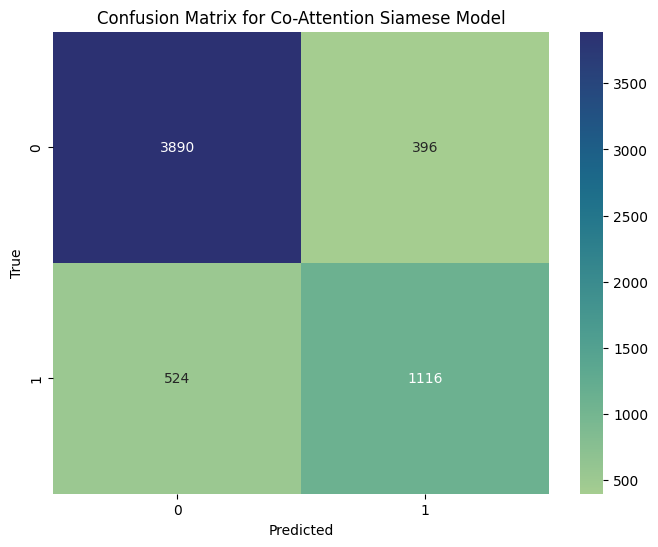

In [13]:
confusion_matrix = confusion_matrix(y_true, y_pred_binary)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='crest', xticklabels=["0", "1"], yticklabels=["0", "1"])
plt.title("Confusion Matrix for Co-Attention Siamese Model")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()